In [1]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import importlib
importlib.reload(tct)
sys.path.append("/Users/jameskitchens/Documents/GitHub/tskit_arg_visualizer")
import tskit_arg_visualizer as tsviz
importlib.reload(tsviz)
import pandas as pd
import tskit
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/terracotta/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
with open("migration_rate_scan/demes.tsv", "w") as out:
    out.write("id\txcoord\tycoord\ttype\tneighbours\n")
    out.write("0\t0\t0\t0\t1\n")
    out.write("1\t1\t0\t0\t0,2\n")
    out.write("2\t2\t0\t0\t1,3\n")
    out.write("3\t3\t0\t0\t2,4\n")
    out.write("4\t4\t0\t0\t3\n")

In [4]:
demes = pd.read_csv("migration_rate_scan/demes.tsv", sep="\t")
world_map = tct.WorldMap(demes)

In [ ]:
tct.create_samples_and_arg_files(
    demes_path="migration_rate_scan/demes.tsv",
    number_of_samples=100,
    sequence_length=125_000,
    recombination_rate=1e-8,
    ploidy=1,
    allow_multiple_samples_per_deme=True,
    pop_size=500,
    migration_rate=0.01,
    output_directory="migration_rate_scan/arg4"
)

In [5]:
def simplify_with_recombination(ts, flag_recomb=False, keep_nodes=None):
    """Simplifies a tree sequence while keeping recombination nodes

    Removes unary nodes that are not recombination nodes. Does not remove non-genetic ancestors.
    Edges intervals are not updated. This differs from how tskit's TreeSequence.simplify() works.

    Parameters
    ----------
    ts : tskit.TreeSequence
    flag_recomb (optional) : bool
        Whether to add msprime node flags. Default is False.
    keep_nodes (optional) : list
        List of node IDs that should be kept. Default is None, so empty list.

    Returns
    -------
    ts_sim : tskit.TreeSequence
        Simplified tree sequence
    maps_sim : numpy.ndarray
        Mapping for nodes in the simplified tree sequence versus the original
    """

    if keep_nodes == None:
        keep_nodes = []

    uniq_child_parent = np.unique(np.column_stack((ts.edges_child, ts.edges_parent)), axis=0)
    child_node, parents_count = np.unique(uniq_child_parent[:, 0], return_counts=True) #For each child, count how many parents it has.
    parent_node, children_count = np.unique(uniq_child_parent[:, 1], return_counts=True) #For each child, count how many parents it has.
    multiple_parents = child_node[parents_count > 1] #Find children who have more than 1 parent. 
    recomb_nodes = ts.edges_parent[np.isin(ts.edges_child, multiple_parents)] #Find the parent nodes of the children with multiple parents. 
    
    if flag_recomb:
        ts_tables = ts.dump_tables()
        node_table = ts_tables.nodes
        flags = node_table.flags
        flags[recomb_nodes] = 131072 #msprime.NODE_IS_RE_EVENT
        node_table.flags = flags
        ts_tables.sort() 
        ts = ts_tables.tree_sequence()
    
    keep_nodes = np.unique(np.concatenate((keep_nodes, recomb_nodes)))
    potentially_uninformative = np.intersect1d(child_node[np.where(parents_count!=0)[0]], parent_node[np.where(children_count==1)[0]])
    truly_uninformative = np.delete(potentially_uninformative, np.where(np.isin(potentially_uninformative, keep_nodes)))
    all_nodes = np.array(range(ts.num_nodes))
    important = np.delete(all_nodes, np.where(np.isin(all_nodes, truly_uninformative)))
    ts_sim, maps_sim = ts.simplify(samples=important, map_nodes=True, keep_input_roots=False, keep_unary=False, update_sample_flags=False)
    return ts_sim, maps_sim

## Migration Rate Scan

0
0.01
1
2
3
4
5


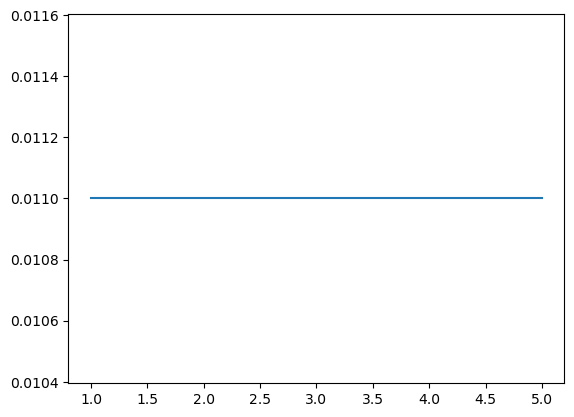

1
0.02
1
2
3
4
5


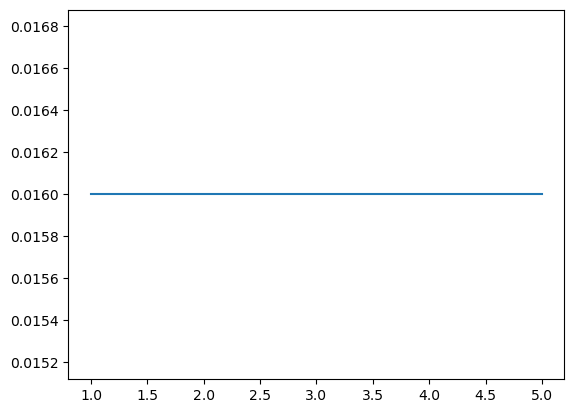

2
0.01
1
2
3
4
5


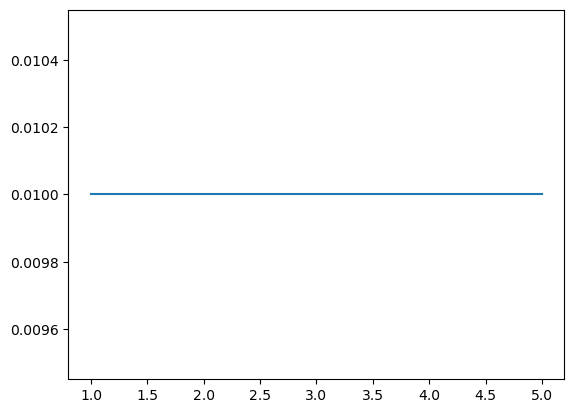

3
0.01
1
2
3
4
5


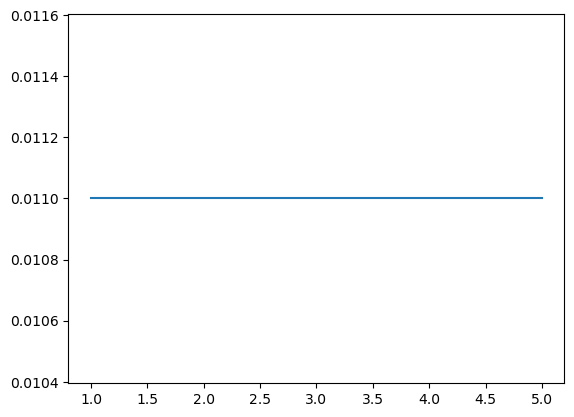

4
0.01
1
2
3
4
5


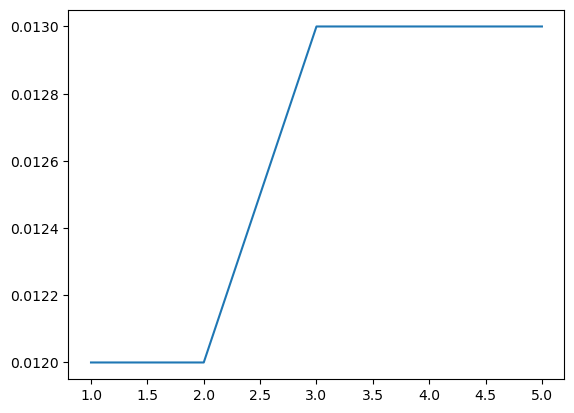

5
0.02
1
2
3
4
5


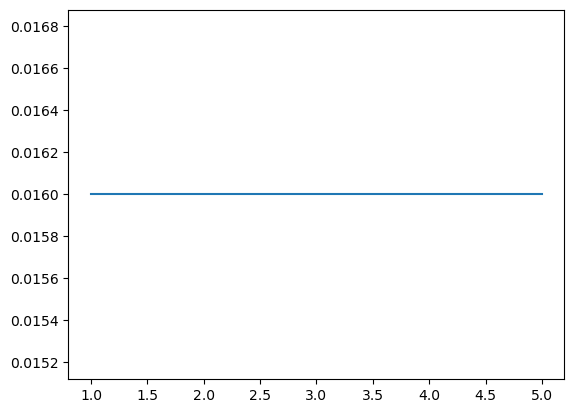

6
0.01
1
2
3
4
5


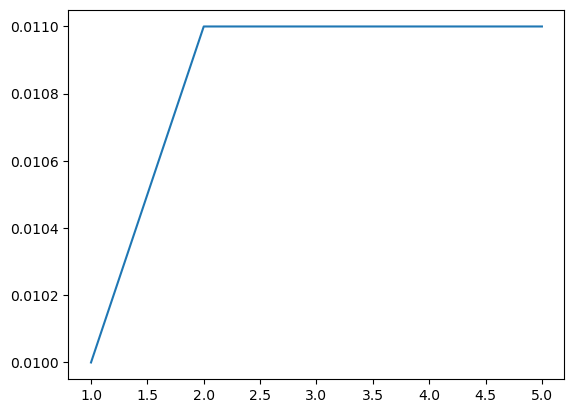

7
0.008
1
2
3
4
5


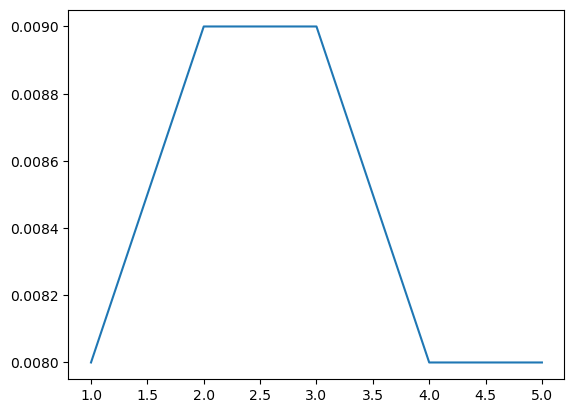

In [14]:
output_num_trees = []
output_max_per_arg = []
output_trees_max_rate = []

for i in range(8):
    print(i)
    ts = tskit.load(f"migration_rate_scan/arg{i}/arg.trees")
    ts, map_nodes = simplify_with_recombination(ts)
    ts = ts.keep_intervals(intervals=[(0,list(ts.breakpoints())[5])], simplify=False).trim()
    sample_locations = pd.read_csv(f"migration_rate_scan/arg{i}/samples.tsv", sep="\t")
    sample_location_vectors = world_map.build_sample_location_vectors(sample_locations=sample_locations)
    
    migration_rates = []
    for m in range(3,-1,-1):
        for i in range(1,10):
            migration_rates.append(i*10**(-m))
    
    trees_max_like = -999999
    trees_max_rate = -1
    for m0 in migration_rates:
        ll = tct.calc_migration_rate_log_likelihood(
            world_map=world_map,
            trees=ts.trees(),
            sample_location_vectors=sample_location_vectors,
            migration_rates={0:m0}
        )
        if ll[0] > trees_max_like:
            trees_max_like = ll[0]
            trees_max_rate = m0
    print(trees_max_rate)
    output_trees_max_rate.append(trees_max_rate)

    args = []
    for bp in ts.breakpoints():
        if bp > 0:
            ts_short = ts.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
            args.append(ts_short)

    num_trees = []
    max_per_arg = []
    for arg in args[:5]:
        print(arg.num_trees)
        max_like = -999999
        max_rate = -1
        for m0 in [trees_max_rate + inc/1000 for inc in range(-4,5)]:
            ll = tct.calc_generalized_migration_rate_log_likelihood(
                world_map=world_map,
                trees=[arg],
                sample_location_vectors=sample_location_vectors,
                migration_rates={0:m0}
            )
            if ll[0] > max_like:
                max_like = ll[0]
                max_rate = m0
        num_trees.append(arg.num_trees)
        max_per_arg.append(max_rate)

    plt.plot(num_trees, max_per_arg)
    plt.show()

    output_num_trees.append(num_trees)
    output_max_per_arg.append(max_per_arg)

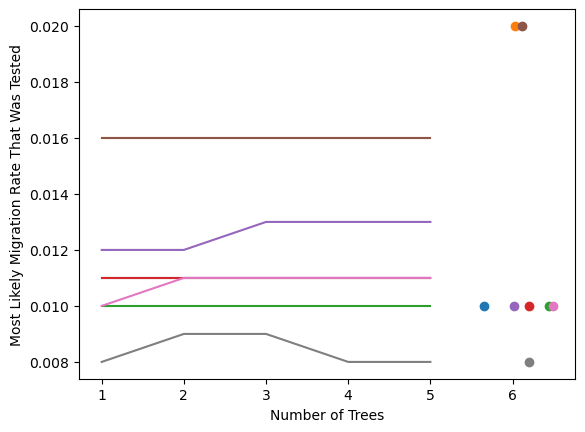

In [30]:
from random import uniform
for i in range(8):
    plt.plot(output_num_trees[i], output_max_per_arg[i])
    plt.scatter([6+uniform(-0.5, 0.5) for i in range(1)], output_trees_max_rate[i])
#plt.hlines(output_trees_max_rate, 1, 5, linestyles="dotted", color="grey")
plt.xlabel("Number of Trees")
plt.ylabel("Most Likely Migration Rate That Was Tested")
plt.savefig("assets/migration_rate_scan.png")
plt.show()

0.008
1
2
3
4
5


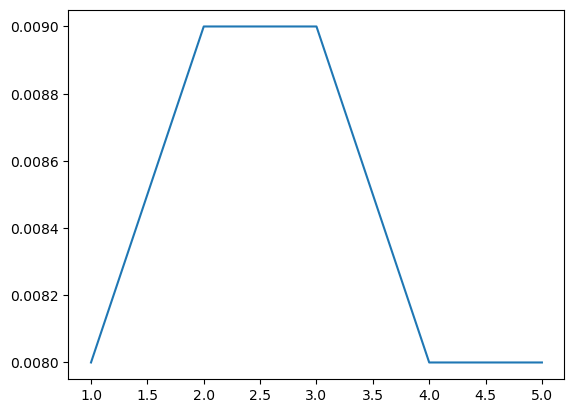

In [12]:
import os

i = 7

os.mkdir(f"migration_rate_scan/arg{i}")

tct.create_samples_and_arg_files(
    demes_path="migration_rate_scan/demes.tsv",
    number_of_samples=100,
    sequence_length=125_000,
    recombination_rate=1e-8,
    ploidy=1,
    allow_multiple_samples_per_deme=True,
    pop_size=500,
    migration_rate=0.01,
    output_directory=f"migration_rate_scan/arg{i}"
)

ts = tskit.load(f"migration_rate_scan/arg{i}/arg.trees")
ts, map_nodes = simplify_with_recombination(ts)
ts = ts.keep_intervals(intervals=[(0,list(ts.breakpoints())[5])], simplify=False).trim()
sample_locations = pd.read_csv(f"migration_rate_scan/arg{i}/samples.tsv", sep="\t")
sample_location_vectors = world_map.build_sample_location_vectors(sample_locations=sample_locations)

migration_rates = []
for m in range(3,-1,-1):
    for i in range(1,10):
        migration_rates.append(i*10**(-m))

trees_max_like = -999999
trees_max_rate = -1
for m0 in migration_rates:
    ll = tct.calc_migration_rate_log_likelihood(
        world_map=world_map,
        trees=ts.trees(),
        sample_location_vectors=sample_location_vectors,
        migration_rates={0:m0}
    )
    if ll[0] > trees_max_like:
        trees_max_like = ll[0]
        trees_max_rate = m0
print(trees_max_rate)

args = []
for bp in ts.breakpoints():
    if bp > 0:
        ts_short = ts.keep_intervals(intervals=[(0,bp)], simplify=False).trim()
        args.append(ts_short)

num_trees = []
max_per_arg = []
for arg in args[:5]:
    print(arg.num_trees)
    max_like = -999999
    max_rate = -1
    for m0 in [trees_max_rate + inc/1000 for inc in range(-4,5)]:
        ll = tct.calc_generalized_migration_rate_log_likelihood(
            world_map=world_map,
            trees=[arg],
            sample_location_vectors=sample_location_vectors,
            migration_rates={0:m0}
        )
        if ll[0] > max_like:
            max_like = ll[0]
            max_rate = m0
    num_trees.append(arg.num_trees)
    max_per_arg.append(max_rate)

plt.plot(num_trees, max_per_arg)
plt.show()